In [1]:
import numpy as np 
from newmethods import *

In [2]:
np.random.seed(49)

In [3]:
# Generate transition matrices

def generate_poisson_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            if s == 0:
                # Boundary condition for state 0:
                P[n, s, 1, s + num_dummy_states] = np.random.rand()  # Stay in state 0
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states]  # Move to state 1
            elif s == num_states - 1:
                # Boundary condition for state 9 (last state):
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to state 8
                P[n, s, 1, s + num_dummy_states] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Stay in state 9
            else:
                # General case for non-boundary states
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to s-1
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Move to s+1

            # Action 0: No pull, move to s+1, unless it's the last state
            if s < num_states - 1:
                P[n, s, 0, s + 1] = 1.0  # Move to s+1 with probability 1
            else:
                P[n, s, 0, s] = 1.0  # Stay in state 9 if it's the last state

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            normal_state_index = s_a - num_states
            # Copy transitions from the corresponding normal state for action 0 within dummy states
            P[n, s_a, 0, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]

    return P

In [4]:
def generate_general_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            # Action 0: Transition within S
            P[n, s, 0, :num_states] = np.random.dirichlet(np.ones(num_states))

            # Action 1: Transition to a dummy state
            P[n, s, 1, num_states:] = np.random.dirichlet(np.ones(num_dummy_states))

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            # Copy transitions from the corresponding normal state for action 0
            normal_state_index = s_a - num_states
            P[n, s_a, 0, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]  # Same for action 1

    return P

In [5]:
def comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations = 2000):
    # Define the reward function, from state 0 (reward 10) to state 9 (reward 1)
    r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards
    # change here to generate different types of transition matrices
    if (mdp_type == 'General'):
        P = generate_general_transition_matrix_with_dummy_states(N, S, S)
    elif (mdp_type == 'Poisson'):
        P = generate_poisson_transition_matrix_with_dummy_states(N, S, S)
    else:
        print("Error")
        return
    P_original = P[:, :S, :, :S]+P[:,:S,:,S:]

    optimal_reward, fluid_reward, fluid_std, fluid_running_time = fluid_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    random_reward, random_std, random_running_time = random_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    no_pull_reward, no_pull_std, no_pull_running_time =  no_pull_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    Q_difference_reward, Q_difference_std, Q_difference_running_time =  Q_difference_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    finite_whittle_reward, finite_whittle_std, finite_whittle_running_time = finite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    infinite_whittle_reward, infinite_whittle_std, infinite_whittle_running_time = infinite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    original_whittle_reward, original_whittle_std, original_whittle_running_time = original_whittle_policy(N, T, S, A, K, group_member_num, P_original, r, num_simulations)


    experiment_synthetic_result = {
        "Optimal": (optimal_reward, None),
        "fluid": (fluid_reward, fluid_std),
        "random": (random_reward, random_std),
        "finite whittle": (finite_whittle_reward, finite_whittle_std),
        "inifinite whittle": (infinite_whittle_reward, infinite_whittle_std),
        "original whittle": (original_whittle_reward, original_whittle_std),
        "Q_difference": (Q_difference_reward, Q_difference_std),
        "no-pull": (no_pull_reward, no_pull_std)
    }

    experiment_running_time_result = {
        'fluid': fluid_running_time,
        'random': random_running_time,
        'no-pull': no_pull_running_time,
        "Q_difference": Q_difference_running_time,
        "finite_whittle": finite_whittle_running_time,
        "infinite_whittle": infinite_whittle_running_time,
        "original_whittle": original_whittle_running_time
    }


    ## If you only collect reward when an arm is pulled,
    ## change the lower_bound_method to "random"
    plot_methods_with_confidence(experiment_synthetic_result, N, T, K, group_member_num, num_simulations, mdp_type, lower_bound_method="no-pull")
    return experiment_synthetic_result, experiment_running_time_result

## Toy Test

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Solver status: optimal
Optimal value: 570.5879822200981
Average total reward over 100 simulations: 1710.41, stdev is 41.98270326857685
Number of pulls in dummy states (LP-based policy): 68
Running Time: 15.35276 seconds
Average total achieved value over 100 simulations (Random policy): 1661.75, stdev is 50.108443007202496
running time: 0.00000 seconds
Average total achieved value over 100 simulations (No-Pull policy): 1670.71, stdev is 46.740265555968165
running time: 0.00000 seconds
Q difference (including dummy states):
Average total achieved value over 100 simulations (General Q difference index policy): 1710.29, stdev is 50.027930582663906
running time: 0.01919 seconds
Finite whittle (including dummy states):
Average total achieved value over 100 simulations (General Finite Whittle index policy): 1708.18, stdev is 56.21430494818985
running time: 23.68858 seconds
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle ind

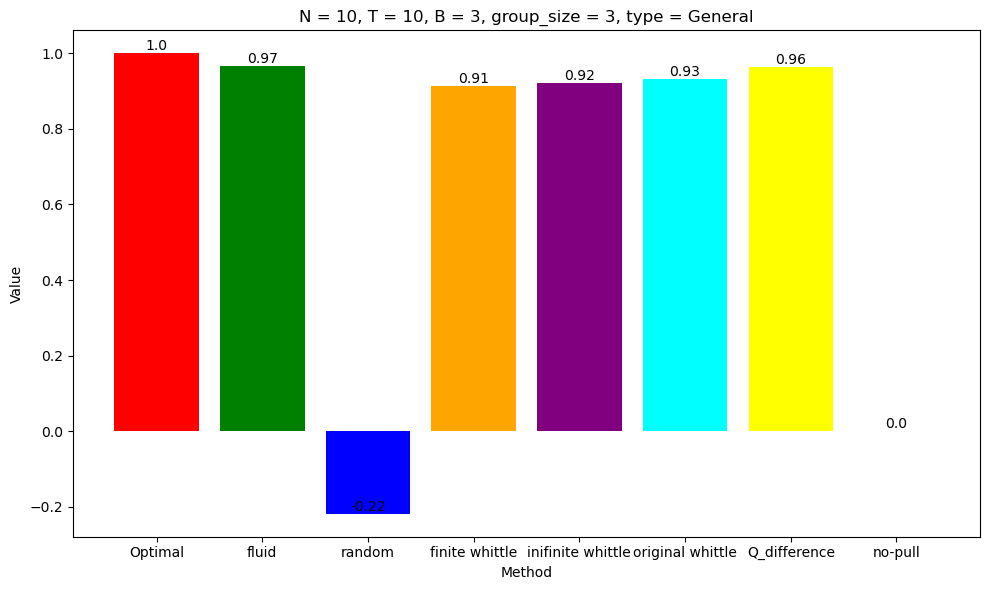

In [6]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 100
mdp_type = 'General'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

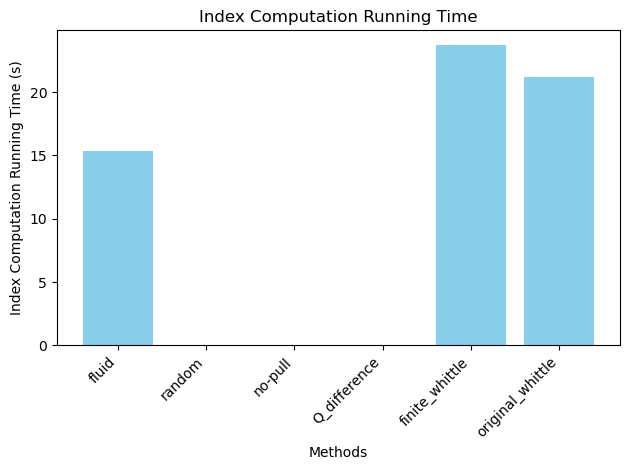

In [7]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

Solver status: optimal
Optimal value: 313.1179249667334
Average total reward over 100 simulations: 921.56, stdev is 109.4384491000039
Number of pulls in dummy states (LP-based policy): 40
Running Time: 15.38278 seconds
Average total achieved value over 100 simulations (Random policy): 841.56, stdev is 91.50374723242626
running time: 0.00000 seconds
Average total achieved value over 100 simulations (No-Pull policy): 780.05, stdev is 88.13870783135987
running time: 0.00000 seconds
Q difference (including dummy states):
Average total achieved value over 100 simulations (General Q difference index policy): 928.61, stdev is 92.8956072071432
running time: 0.01931 seconds
Finite whittle (including dummy states):
Average total achieved value over 100 simulations (General Finite Whittle index policy): 933.84, stdev is 107.39041583931693
running time: 21.66065 seconds
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle index polic

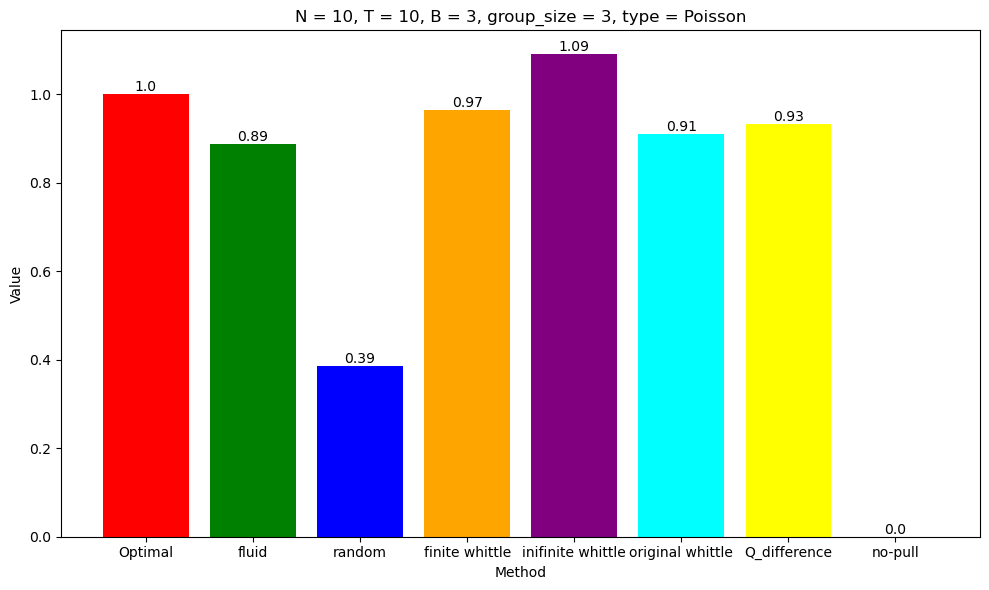

In [8]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 100
mdp_type = 'Poisson'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

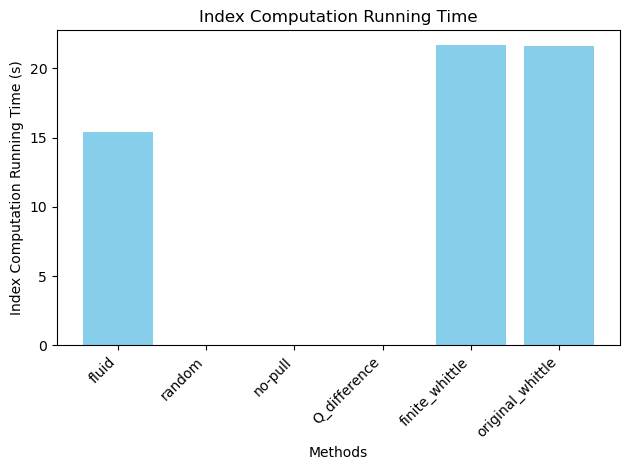

In [9]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 15, N = 10, T = 10, group_size = 10, B = 10, General

Solver status: optimal
Optimal value: 817.2824715931695
Average total reward over 2000 simulations: 8147.5375, stdev is 136.41990246530864
Number of pulls in dummy states (LP-based policy): 1377
Running Time: 39.25864 seconds
Average total achieved value over 2000 simulations (Random policy): 7999.1055, stdev is 136.1052338710512
running time: 0.00000 seconds
Average total achieved value over 2000 simulations (No-Pull policy): 8008.171, stdev is 137.06479904982638
running time: 0.00000 seconds
Q difference (including dummy states):
Average total achieved value over 2000 simulations (General Q difference index policy): 8167.174, stdev is 137.49129300368773
running time: 0.04228 seconds
Finite whittle (including dummy states):
Average total achieved value over 2000 simulations (General Finite Whittle index policy): 8164.9465, stdev is 137.04527478691378
running time: 78.37293 seconds
Whittle Indices (including dummy states):
Average total achieved value over 2000 simulations (General Inf

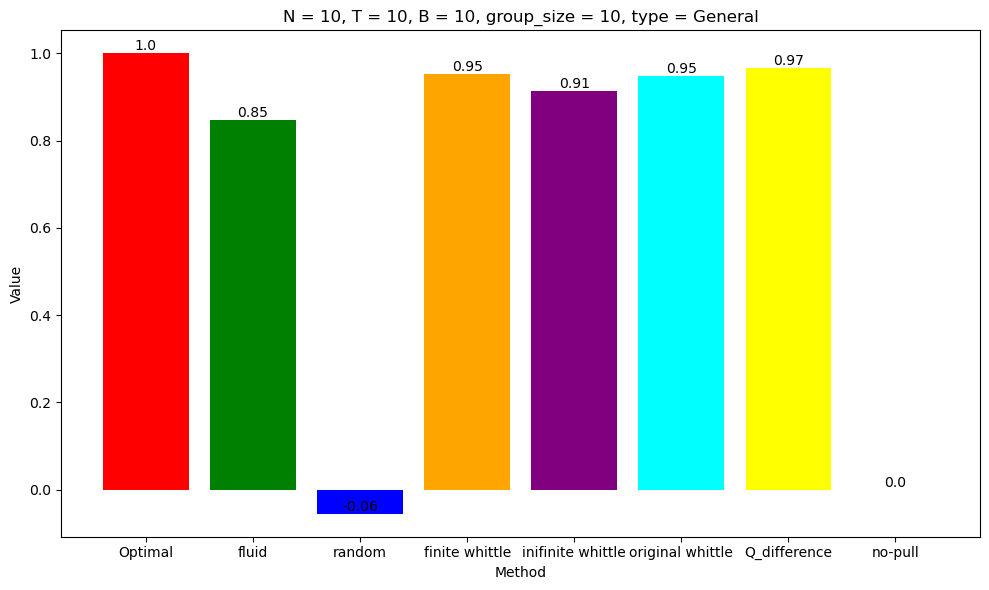

In [10]:
S = 15
N = 10
T = 10
group_member_num = 10
K = 10
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'General'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

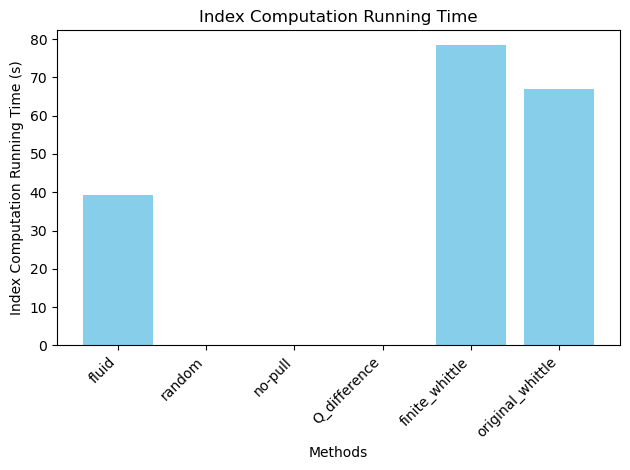

In [11]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 15, N = 10, T = 10, group_size = 10, B = 10, Poisson

In [12]:
S = 15
N = 10
T = 10
group_member_num = 10
K = 10
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'Poisson'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

Solver status: optimal
Optimal value: 524.296708989427
Average total reward over 2000 simulations: 5197.1885, stdev is 345.5210172398015
Number of pulls in dummy states (LP-based policy): 0
Running Time: 41.11640 seconds
Average total achieved value over 2000 simulations (Random policy): 4897.482, stdev is 325.01594477529727
running time: 0.00000 seconds
Average total achieved value over 2000 simulations (No-Pull policy): 4604.611, stdev is 309.882328001459
running time: 0.00000 seconds
Q difference (including dummy states):
Average total achieved value over 2000 simulations (General Q difference index policy): 5209.2035, stdev is 343.89286738731573
running time: 0.04286 seconds


KeyboardInterrupt: 

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 20, T = 5, group_size = 10, B = 30, General

In [ ]:
S = 10
N = 20
T = 5
group_member_num = 10
K = 30
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'General'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 20, T = 5, group_size = 10, B = 30, Poisson

In [ ]:
S = 10
N = 20
T = 5
group_member_num = 10
K = 30
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'Poisson'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 30, T = 10, group_size = 10, B = 10, General

In [ ]:
S = 10
N = 30
T = 10
group_member_num = 10
K = 10
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'General'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 30, T = 10, group_size = 10, B = 10, Poisson

In [ ]:
S = 10
N = 30
T = 10
group_member_num = 10
K = 10
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'Poisson'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 20, T = 5, group_size = 50, B = 150, General

In [ ]:
S = 10
N = 20
T = 5
group_member_num = 50
K = 150
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'General'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)

S = 10, N = 20, T = 5, group_size = 50, B = 150, Poisson

In [ ]:
S = 10
N = 20
T = 5
group_member_num = 50
K = 150
S_prime = S * 2
A = 2

num_simulations = 2000
mdp_type = 'Poisson'
test_result, running_time_result = comparison(S, N, group_member_num, K, S_prime, A, T, mdp_type, num_simulations)

In [ ]:
plot_running_time(running_time_result, N, T, K, group_member_num, mdp_type)